<div>
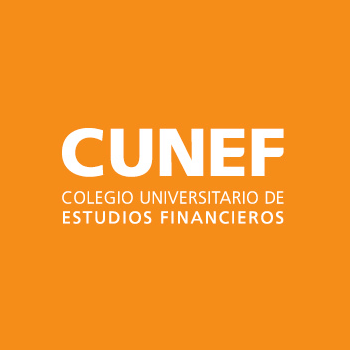
</div>

# **Producto Interior Bruto**
En este notebook se mostrará la serie temporal del **Producto Interior Bruto (PIB)** y observaremos cómo le afectó frente al COVID-19.

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura, preprocesado e intervención del momento COVID-19
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
        4.4) Comparativa errores y elección del mejor modelo
    5) Predicción hasta finales de año

## *1) Librerías utilizadas*



In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del CSV y preprocesado de los datos*
Se procede a leer el archivo CSV del PIB trimestral español:

- Fuente: Instituto Nacional de Estadística (INE)

In [65]:
df_pib = pd.read_csv("pibtrimestral.csv", sep = ";", encoding='latin-1')
df_pib

,Tipo de dato,Agregados macroeconómicos: Nivel 1,Agregados macroeconómicos: Nivel 2,Niveles y tasas,Periodo,total
0,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T1,109165
1,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T2,116633
2,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T3,112398
3,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T4,122392
4,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1996T1,115776
...,...,...,...,...,...,...
105,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T2,300089
106,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T3,297498
107,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T4,327744
108,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2022T1,310012


Hacemos una limpieza de columnas y filas para escoger solo el total del PIB desde enero del 2010 hasta el último registro trimestral (**Recalcar que este dataset está actualizado hasta el primer trimestre del 2022**)

In [66]:
df_pib = df_pib.iloc[60:109,-2:]
df_pib.tail()

,Periodo,total
104,2021T1,279732
105,2021T2,300089
106,2021T3,297498
107,2021T4,327744
108,2022T1,310012


In [67]:
df_pib['Periodo'] = df_pib['Periodo'].str.replace('T', 'Q')
df_pib['Periodo'] = pd.to_datetime(df_pib['Periodo'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors= 'coerce')
df_pib.tail()

,Periodo,total
104,2021-01-01,279732
105,2021-04-01,300089
106,2021-07-01,297498
107,2021-10-01,327744
108,2022-01-01,310012


In [68]:
# convert to period
df_pib['Periodo'] = pd.to_datetime(df_pib['Periodo']).dt.to_period('M')
df_pib = df_pib.set_index('Periodo').resample('M').interpolate()


Por último, observamos si hay algún valor nulo o faltante para poder realizar posteriormente los gráficos de las componentes estacionales:

In [69]:
df_pib.isnull().sum()

total    0
dtype: int64


## *3) EDA*

Text(0.5, 0, 'Periodo')

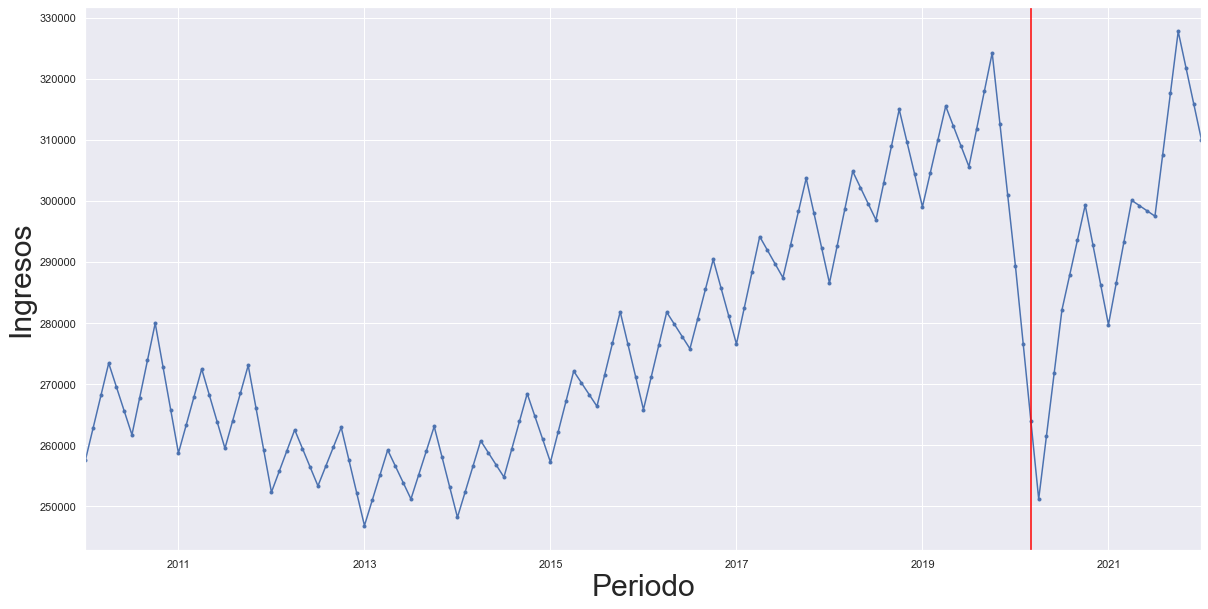

In [70]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_pib.total.plot(marker='.') 
fig.set_ylabel('Ingresos', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30)
# fig.figure.savefig('../pics/df_pib/tendencia.png')

Podemos observar que el PIB presentó una clara **tendencia positiva hasta el inicio de la pandemia**, la cual bajó vertiginosamente hasta las 200.000 ud aunque está recuperándose también rápidamente.

A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

### 3.1) Cálculo de la media y de la varianza

In [71]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

mean = split_and_summarize(df_pib, 'total', 4, np.mean)
variance = split_and_summarize(df_pib, 'total', 4, np.var)

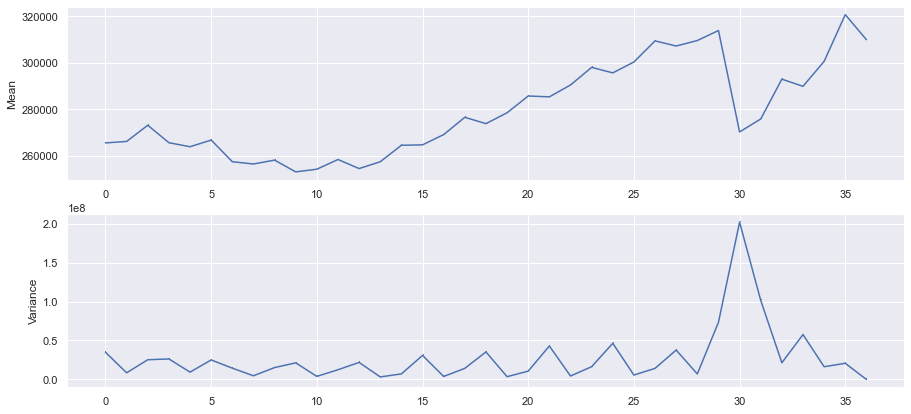

In [72]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()
# fig.figure.savefig('../pics/df_pib/meanvariance.png')

Por la media se puede ver que no es una serie estacionaria, pero como la varianza confunde un poco por el pico, probaremos el test de Dickey-Fuller aumentado:

### 3.2) Test de Dickey-Fuller aumentado

In [73]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_pib)

Results of Dickey-Fuller Test:
Test Statistic                  -0.815149
p-value                          0.814632
#Lags Used                      10.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


**La serie temporal NO es estacionaria**, debido a que el p-value del test Dickey-Fuller (0.81) es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-0.81) es bastante mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas de comportamiento mensual
A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

Text(0.5, 1.0, 'Comportamiento Estacional')

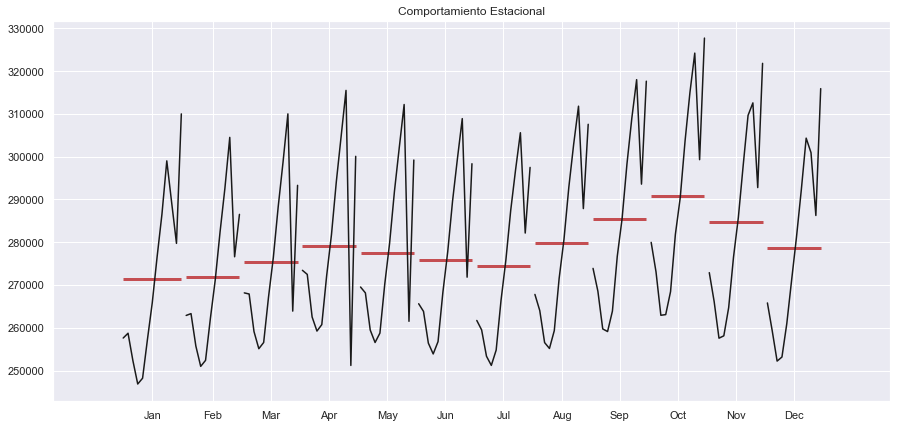

In [74]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_pib.total, ax=ax)
ax.set_title('Comportamiento Estacional')
# ax.figure.savefig('../pics/df_pib/monthbehavior.png')

Text(0.5, 1.0, 'Comportamiento estacional')

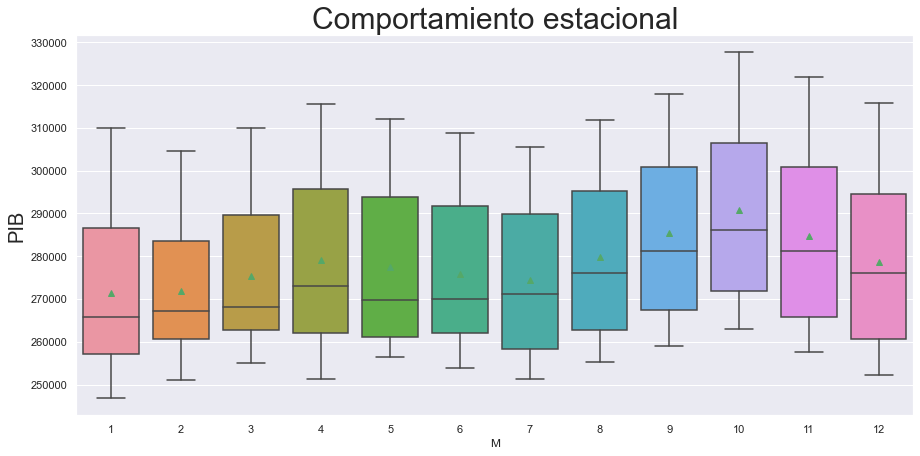

In [75]:
df_pib['M'] = df_pib.index.month
sns.boxplot(data = df_pib, x = 'M', y='total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('PIB', fontsize = 20)
ax.set_title('Comportamiento estacional', fontsize = 30)
# ax.figure.savefig('../pics/df_pib/boxplotmonth')

**No se aprecia una estacionalidad clara** ya que los valores están en torno a las 260.000 y 290.000 ud. 

### 3.4) Descomposición

In [76]:
# index to timestamp
df_pib.index = df_pib.index.to_timestamp()

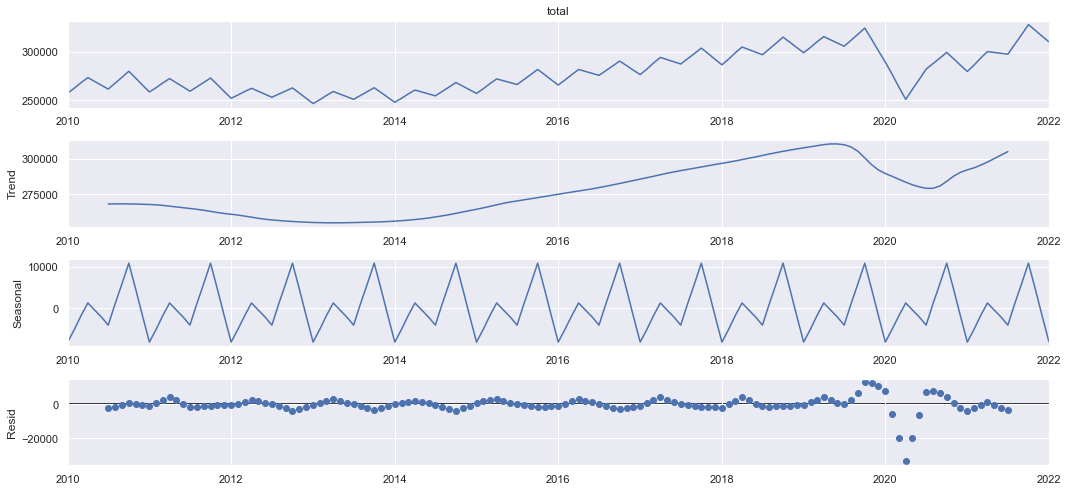

In [77]:
desglose = seasonal_decompose(df_pib.total, 
                              model='additive',
                              period=12);
desglose.plot();
# plt.savefig('../pics/df_pib/decompose.png')

Como conclusión:
- Tiene tendencia positiva hasta el inicio de la pandemia, baja y ahora está recuperándose.
- No tiene una estacionalidad ni tampoco es una serie estacionaria.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta julio del 2022, hay 29 meses para el test_size.



Cantidad de períodos en Train: 116
Cantidad de períodos en Test: 29


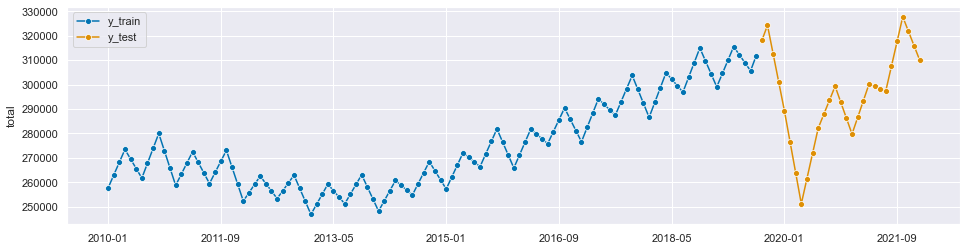

In [78]:
#Train-test
y_train, y_test = temporal_train_test_split(
    y=df_pib['total'].astype('float64').to_period('M'),test_size=29)
#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [79]:
y_test.round() #observamos los 29 meses testeados

2019-09    318022.0
2019-10    324228.0
2019-11    312587.0
2019-12    300946.0
2020-01    289305.0
2020-02    276599.0
2020-03    263893.0
2020-04    251187.0
2020-05    261508.0
2020-06    271828.0
2020-07    282149.0
2020-08    287868.0
2020-09    293588.0
2020-10    299307.0
2020-11    292782.0
2020-12    286257.0
2021-01    279732.0
2021-02    286518.0
2021-03    293303.0
2021-04    300089.0
2021-05    299225.0
2021-06    298362.0
2021-07    297498.0
2021-08    307580.0
2021-09    317662.0
2021-10    327744.0
2021-11    321833.0
2021-12    315923.0
2022-01    310012.0
Freq: M, Name: total, dtype: float64

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [80]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
pib_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [81]:
pib_auto_ets.fit(y_train)
pib_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  total   No. Observations:                  116
Model:                       ETS(MAM)   Log Likelihood                -993.836
Date:                Mon, 29 Aug 2022   AIC                           2023.672
Time:                        19:26:13   BIC                           2073.237
Sample:                    01-31-2010   HQIC                          2043.792
                         - 08-31-2019   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.126      7.930      0.000       0.753       1.247
smoothing_trend         0.0806      0.030      2.650      0.008       0.021       0.140
smoothing_seasonal   1.992e-05      0.125      0.000      1.000      -0.246       0.246
initial_level        2.688e+05        nan        nan        nan         nan         nan
initial_trend        -157.0005    502.371     -0.313      0.755   -1141.629     827.628
initial_seasonal.0      1.0222        nan        nan        nan         nan         nan
initial_seasonal.1      1.0443        nan        nan        nan         nan         nan
initial_seasonal.2      1.0665        nan        nan        nan         nan         nan
initial_seasonal.3      1.0497        nan        nan        nan         nan         nan
initial_seasonal.4      1.0327        nan        nan        nan         nan         nan
initial_seasonal.5      1.0156        nan        nan        nan         nan         nan
initial_seasonal.6      1.0276        nan        nan        nan         nan         nan
initial_seasonal.7      1.0396        nan        nan        nan         nan         nan
initial_seasonal.8      1.0516        nan        nan        nan         nan         nan
initial_seasonal.9      1.0345        nan        nan        nan         nan         nan
initial_seasonal.10     1.0173        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       25.33   Jarque-Bera (JB):             14526.09
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -6.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [82]:
#step 5: querying predictions
pib_pred = pib_auto_ets.predict(fh=list(fh))
pib_pred.round()

2019-09    317698.0
2019-10    323574.0
2019-11    317610.0
2019-12    311616.0
2020-01    305593.0
2020-02    311625.0
2020-03    317654.0
2020-04    323678.0
2020-05    320749.0
2020-06    317796.0
2020-07    314820.0
2020-08    320888.0
2020-09    326918.0
2020-10    332941.0
2020-11    326782.0
2020-12    320594.0
2021-01    314377.0
2021-02    320561.0
2021-03    326741.0
2021-04    332915.0
2021-05    329881.0
2021-06    326822.0
2021-07    323740.0
2021-08    329959.0
2021-09    336137.0
2021-10    342309.0
2021-11    335955.0
2021-12    329572.0
2022-01    323160.0
Freq: M, dtype: float64

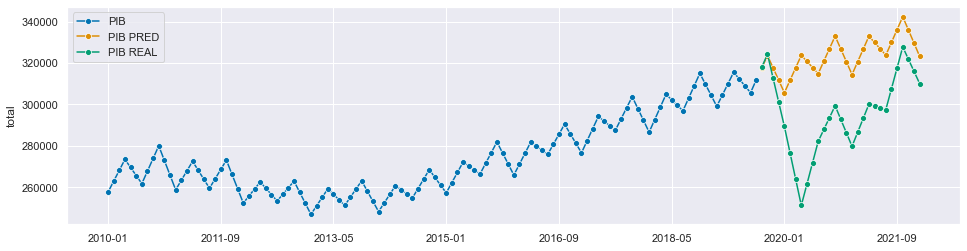

In [83]:
# optional: plotting predictions and past data
plot_series(y_train, pib_pred, y_test, labels=["PIB", "PIB PRED", "PIB REAL"])
plt.show()

Se hace un zoom al gráfico:

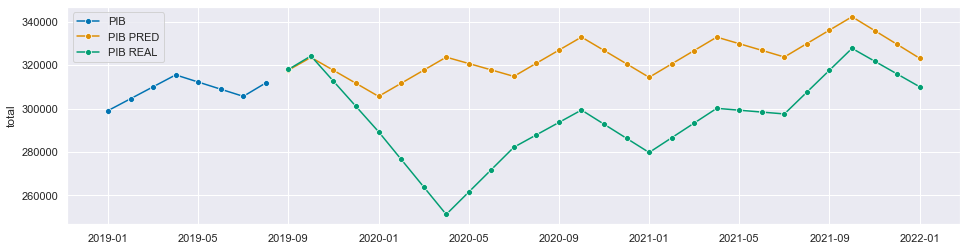

In [84]:
plot_series(y_train["2019":], pib_pred,y_test, labels=["PIB", "PIB PRED", "PIB REAL"]);

La predicción por ETS, a simple vista, no predice el momento COVID, pero a partir de después del verano del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [85]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, pib_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 32557.9


In [86]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, pib_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 9.91%


### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [87]:
transformer = LogTransformer()
log_df_pib= transformer.fit_transform(df_pib['total'])
log_df_pib.tail()

Periodo
2021-09-01    12.668743
2021-10-01    12.699988
2021-11-01    12.681789
2021-12-01    12.663253
2022-01-01    12.644366
Freq: MS, dtype: float64

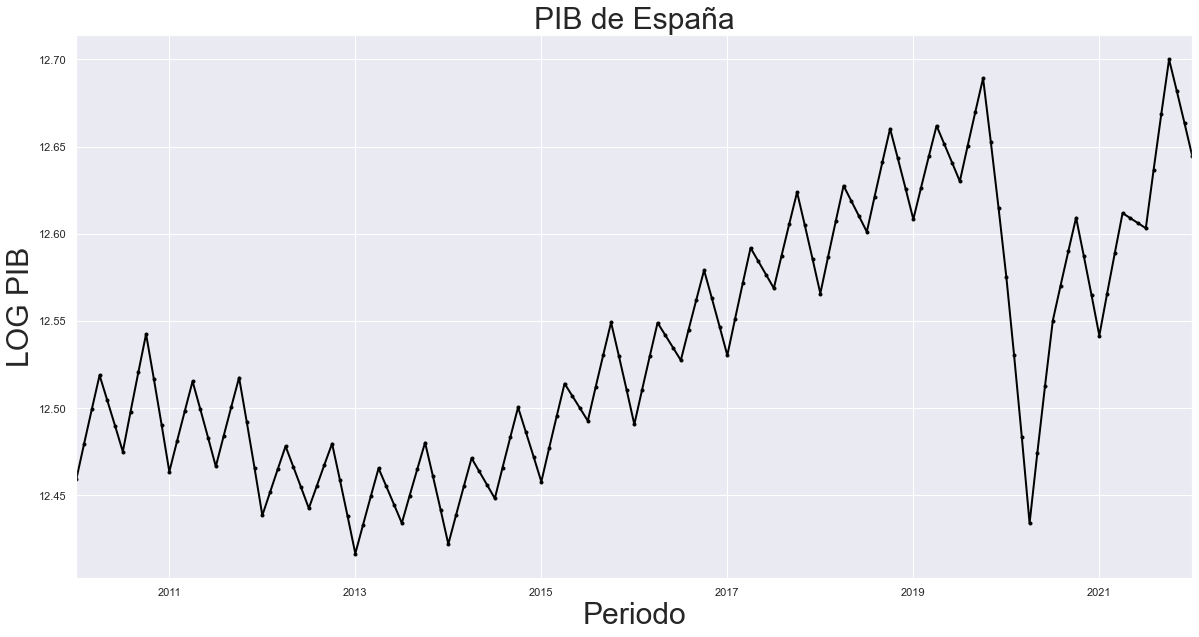

In [88]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_pib.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('PIB de España', fontsize = 30) 
fig.set_ylabel('LOG PIB', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

116 29


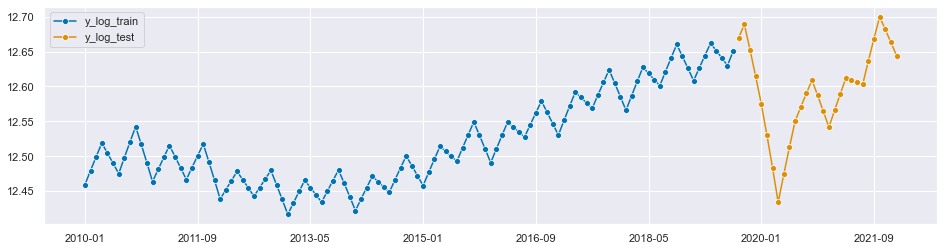

In [89]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_pib.astype('float64').to_period('M').sort_index(),test_size=29)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [90]:
fh = np.arange(1,y_log_test.shape[0]+1)
pib_auto_arima=AutoARIMA(sp=12,suppress_warnings=True)

In [91]:
pib_auto_arima.fit(y_log_train)
pib_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 563.303
Date:                            Mon, 29 Aug 2022   AIC                          -1108.606
Time:                                    19:27:14   BIC                          -1083.902
Sample:                                         0   HQIC                         -1098.579
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.156e-05      0.000      0.153      0.878      -0.000       0.000
ar.L1          0.1230      0.202      0.608      0.543      -0.273       0.519
ma.L1          0.8568      0.215      3.978      0.000       0.435       1.279
ma.L2          0.7907      0.063     12.553      0.000       0.667       0.914
ar.S.L12       0.1275      0.067      1.895      0.058      -0.004       0.259
ar.S.L24       0.8481      0.067     12.628      0.000       0.716       0.980
ma.S.L12       1.0992      0.112      9.825      0.000       0.880       1.319
ma.S.L24       0.7321      0.141      5.204      0.000       0.456       1.008
sigma2      1.613e-06   2.15e-07      7.507      0.000    1.19e-06    2.03e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                68.57
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
pib_log_pred = pib_auto_arima.predict(fh)
np.exp(pib_log_pred)

2019-09    318177.422233
2019-10    324647.863722
2019-11    317997.180156
2019-12    311375.432540
2020-01    304784.598752
2020-02    310328.889232
2020-03    315874.954193
2020-04    321422.682927
2020-05    317806.435190
2020-06    314191.468073
2020-07    310577.830759
2020-08    316838.137892
2020-09    323287.338384
2020-10    329869.491631
2020-11    323679.750610
2020-12    317494.648932
2021-01    311312.875349
2021-02    316387.549036
2021-03    321465.900944
2021-04    326547.675748
2021-05    322698.416827
2021-06    318848.479840
2021-07    314997.852559
2021-08    321029.397010
2021-09    327333.754446
2021-10    333830.230564
2021-11    327240.593403
2021-12    320673.893180
2022-01    314130.798390
Freq: M, dtype: float64

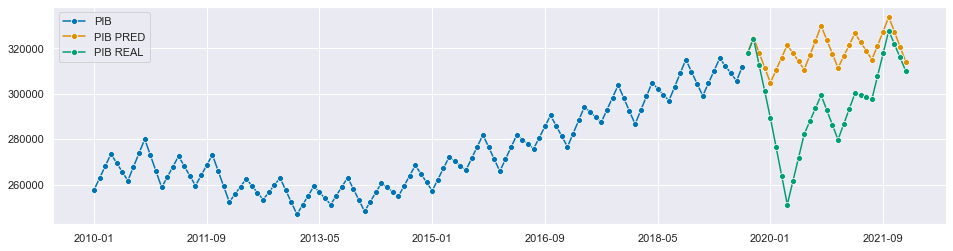

In [93]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(pib_log_pred), np.exp(y_log_test),
            labels=["PIB", "PIB PRED", "PIB REAL"])
plt.show()

In [94]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(pib_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 29094.92


In [95]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(pib_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 8.42%


#### Una comparativa entre ETS y ARIMA

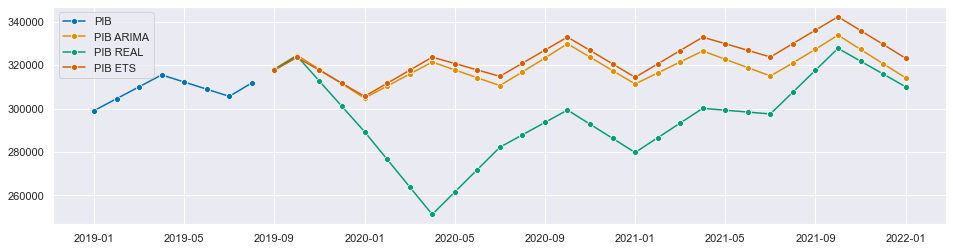

In [96]:
plot_series(np.exp(y_log_train["2019":]), np.exp(pib_log_pred), np.exp(y_log_test), pib_pred, 
            labels=["PIB", "PIB ARIMA", "PIB REAL", 'PIB ETS'])
plt.show()
# plt.savefig('../pics/df_pib/etsarima.png)')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [97]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 32557.9
El modelo ARIMA genera un RMSE de: 29094.92


In [98]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 9.91%
El modelo ARIMA genera un MAPE de 8.42%


Confirmamos que el modelo ARIMA, para este caso concreto, predice algo mejor ya que su error es menor.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 


Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [99]:
df_pib=df_pib.drop('M',axis=1)

In [100]:
prophet_train = df_pib.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [101]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

116

In [102]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

In [103]:
prophet_y_train.round()

,ds,y
0,2010-01-31,257598.0
1,2010-02-28,262877.0
2,2010-03-31,268155.0
3,2010-04-30,273434.0
4,2010-05-31,269525.0
...,...,...
111,2019-04-30,315507.0
112,2019-05-31,312208.0
113,2019-06-30,308910.0
114,2019-07-31,305611.0


In [104]:
y_test.round()

2019-09    318022.0
2019-10    324228.0
2019-11    312587.0
2019-12    300946.0
2020-01    289305.0
2020-02    276599.0
2020-03    263893.0
2020-04    251187.0
2020-05    261508.0
2020-06    271828.0
2020-07    282149.0
2020-08    287868.0
2020-09    293588.0
2020-10    299307.0
2020-11    292782.0
2020-12    286257.0
2021-01    279732.0
2021-02    286518.0
2021-03    293303.0
2021-04    300089.0
2021-05    299225.0
2021-06    298362.0
2021-07    297498.0
2021-08    307580.0
2021-09    317662.0
2021-10    327744.0
2021-11    321833.0
2021-12    315923.0
2022-01    310012.0
Freq: M, Name: total, dtype: float64

In [105]:
m = Prophet()
m.fit(prophet_y_train)

19:27:15 - cmdstanpy - INFO - Chain [1] start processing
19:27:15 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

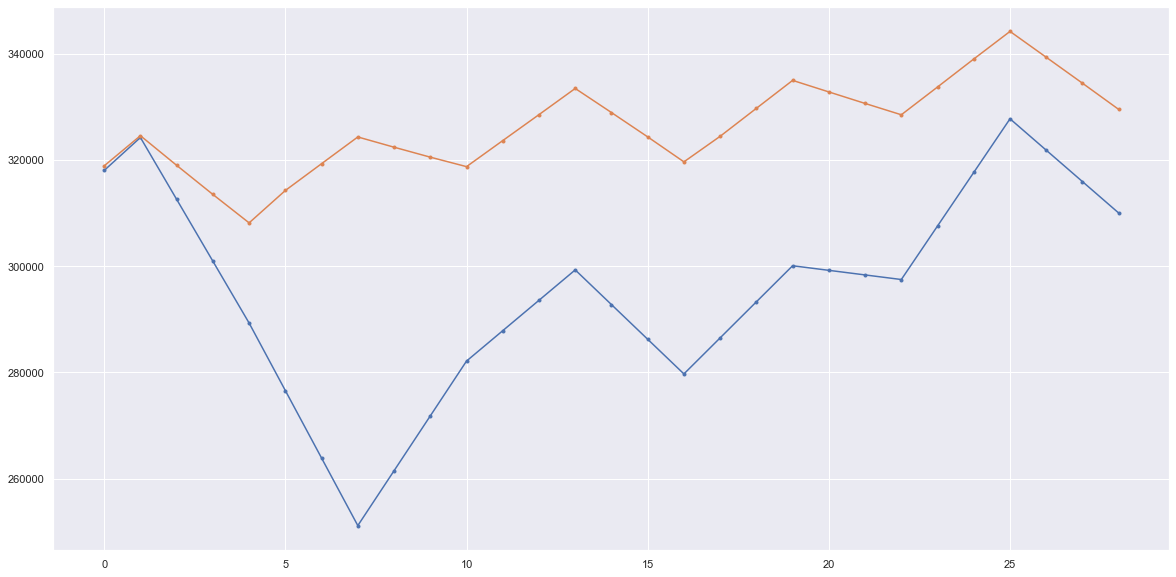

In [107]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[116:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_pib/prophet.png')

In [108]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[116:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 10.84%


In [109]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[116:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 34928.11


In [110]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
140,2021-09-30,339002.0,331431.0,346607.0
141,2021-10-31,344193.0,336481.0,352363.0
142,2021-11-30,339323.0,331176.0,347755.0
143,2021-12-31,334441.0,325797.0,343407.0
144,2022-01-31,329510.0,320359.0,338623.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [111]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 32557.9
El modelo ARIMA genera un RMSE de: 29094.92
El modelo Prophet genera un RMSE de: 34928.11


2) MAPE (Error porcentual)

In [112]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 9.91%
El modelo ARIMA genera un MAPE de 8.42%
El modelo Prophet genera un MAPE de 10.84%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ARIMA**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*
Para la predicción de una serie no estacionaria, haremos primero el cálculo en número log y luego se traspasa a número normal.

In [120]:
fh = np.arange(6)+1  
forecaster = AutoARIMA(sp=12,suppress_warnings=True)
y = transformer.fit_transform(df_pib['total'].astype('float64').to_period('M').sort_index())
forecaster.fit(y)

AutoARIMA(sp=12, suppress_warnings=True)

In [121]:
print(forecaster.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  145
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 475.199
Date:                                 Mon, 29 Aug 2022   AIC                           -932.397
Time:                                         19:33:57   BIC                           -905.669
Sample:                                              0   HQIC                          -921.536
                                                 - 145                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7214      0.315      2.288      0.022       0.103       1

In [127]:
pib_pred = forecaster.predict(fh=list(fh))
pib_pred

2022-02    12.635788
2022-03    12.626954
2022-04    12.617070
2022-05    12.625767
2022-06    12.634501
2022-07    12.643142
Freq: M, dtype: float64

In [126]:
np.exp(pib_pred) # a número

2022-02    307363.991506
2022-03    304660.608089
2022-04    301664.328410
2022-05    304299.141774
2022-06    306968.652677
2022-07    309632.615694
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

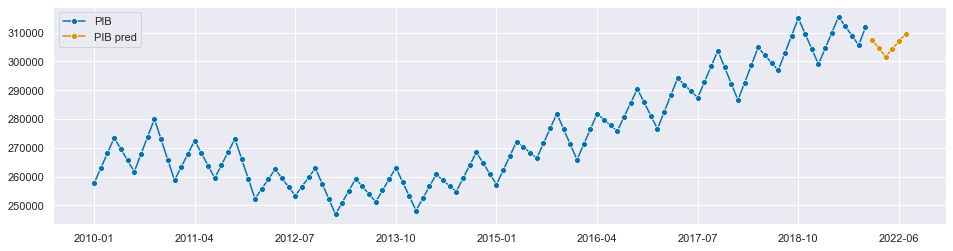

In [125]:
plot_series(np.exp(y_log_train), np.exp(pib_pred), labels=["PIB", "PIB pred"])
# plt.savefig('../pics/df_pib/pred2022.png')